# Imports

In [1]:
import pandas as pd

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import neighbors, datasets
from matplotlib.colors import ListedColormap
from sklearn import metrics
from sklearn.metrics import accuracy_score 
import plot_utils
from statistics import mean 

# Read Data Set

In [2]:
df = pd.read_csv("mergeData_fixed_time.csv")
df = df.drop('total_time', axis=1) 
pd.options.display.max_columns = None
df.head()

,pedId,speed_total_mean,steering_total_mean,brake_total_mean,throttle_total_mean,acceleration_total_mean,speed_total_var,steering_total_var,brake_total_var,throttle_total_var,acceleration_total_var,distancePed,max_speed,PKE,PKE_Steering,speed_react,reaction_time,pedestriansLevel,visibilityLevel,trafficLevel,gender,age,job,LatestDegree,oftenDrive,accidents,yearsDriving,lastDrive(years),speedingTickets,hadCollision
0,1.0,6.978462,0.493644,0.947244,0.813465,-0.000623,13.607109,0.000420,0.021339,0.032907,0.050404,68.920520,11.669766,1.110623,-0.000432,7.754880,1.048791,0,1,0,0,32,0,0,2,0,10,1.0,0,0
1,3.0,7.045599,0.504890,0.875541,0.911211,-0.045255,33.663919,0.000176,0.065360,0.002429,0.068962,69.359540,13.499710,0.084626,0.000000,13.472353,2.106615,0,1,0,0,32,0,0,2,0,10,1.0,0,0
2,15.0,10.263041,0.478319,0.817679,0.595013,-0.017068,76.873997,0.001610,0.105119,0.076302,0.705761,96.885284,25.851397,5.246326,0.000170,25.585112,0.079211,0,1,0,0,32,0,0,2,0,10,1.0,0,1
3,2.0,11.669419,0.500661,0.891913,0.522365,0.008028,47.209285,0.000396,0.055982,0.112551,0.159198,88.011610,20.055070,2.969647,-0.000258,19.412087,1.161592,2,1,0,0,32,0,0,2,0,10,1.0,0,0
4,4.0,12.187044,0.499769,0.861132,0.558120,0.001881,42.031423,0.000430,0.102442,0.079023,0.158822,105.973686,19.697004,4.033468,0.000066,18.461056,1.275896,2,1,0,0,32,0,0,2,0,10,1.0,0,0


### Distribution of cases

In [3]:
num_obs = len(df)
num_true = len(df.loc[df['hadCollision'] == 1])
num_false = len(df.loc[df['hadCollision'] == 0])
print("Number of True cases:  {0} ({1:2.2f}%)".format(num_true, (num_true/num_obs) * 100))
print("Number of False cases: {0} ({1:2.2f}%)".format(num_false, (num_false/num_obs) * 100))

Number of True cases:  37 (7.60%)
Number of False cases: 450 (92.40%)


We have considerably more false cases than true ones.

# Predictions

First I will start with the DecisionTree that made the feature importances plot.

### Auxiliar function for random repeats

In [4]:
from sklearn.model_selection import train_test_split
data = df.copy()
X = data.drop('hadCollision', axis=1) 
Y = data['hadCollision']

def default_train_test_split(test_size):
    return train_test_split(X, Y, test_size=test_size, stratify=Y)

def repite_model_predict_algorithm( fit_function, predict_function, repetitions=50, test_size=0.4, split_fuction=default_train_test_split):
    y_pred_total = []
    y_test_total = []
    for i in range(repetitions):
        X_train, X_test, y_train, y_test = split_fuction(test_size)
        fit_function(X_train, y_train)
        y_pred = predict_function(X_test)
        y_pred_total.append(y_pred)
        y_test_total.append(y_test)
    
    plot_utils.print_header("Multiple experiments average result:")
    summarize_multiple_experiments_average_results(y_test_total, y_pred_total)
    
    plot_utils.print_header("Sum of all experiments results:")
    summarize_one_big_experiment_results(y_test_total, y_pred_total)

def summarize_multiple_experiments_average_results(y_test_total, y_pred_total):
    total_acc, no_hit_prec, no_hit_rec, no_hit_fscore, hit_prec, hit_rec, hit_fscore, kappa = ([] for i in range(8))
    for y_true,y_pred in zip(y_test_total, y_pred_total):
        cr = metrics.classification_report(y_true, y_pred, output_dict=True, zero_division=0)
        total_acc.append(cr['accuracy']*100)
        no_hit_prec.append(cr['0']['precision'])
        no_hit_rec.append(cr['0']['recall'])
        no_hit_fscore.append(cr['0']['f1-score'])
        hit_prec.append(cr['1']['precision'])
        hit_rec.append(cr['1']['recall'])
        hit_fscore.append(cr['1']['f1-score'])
        kappa.append(metrics.cohen_kappa_score(y_true, y_pred, labels=None, weights=None))
    print("Total Accuracy: %{0:.2f}".format(average(total_acc)))
    print("Cohen's kappa coefficient: {0:.2f}".format(average(kappa)))
    means = [[average(no_hit_prec), average(no_hit_rec), average(no_hit_fscore)], 
             [average(hit_prec), average(hit_rec), average(hit_fscore)]]
    plot_utils.plot_classification_report_means(means)
    plot_utils.plot_confusion_matrix([[average(no_hit_rec), 1 - average(no_hit_rec)],
                                      [1 - average(hit_rec), average(hit_rec)]])
    plot_utils.print_result(average(kappa))
    plot_utils.print_result(average(total_acc), 92.31, "Total Accuracy percentaje", '%')
    plot_utils.print_result(average(hit_prec), 0, "Hit Precision")
    plot_utils.print_result(average(hit_rec), 0, "Hit Recall")
    plot_utils.print_result(average(no_hit_prec), 0.92, "No Hit Precision")
    plot_utils.print_result(average(no_hit_rec), 1, "No Hit Recall")
    
def average(values):
    return round(mean(values), 2)
    
def summarize_one_big_experiment_results(y_test_total, y_pred_total):
    y_test_total = [val for sublist in y_test_total for val in sublist]
    y_pred_total = [val for sublist in y_pred_total for val in sublist]
    lookup = {0: 'No Hit', 1:'Yes Hit'}
    y_true_pd = pd.Series([lookup[_] for _ in y_test_total])
    y_pred_pd = pd.Series([lookup[_] for _ in y_pred_total])
    

    print("Confusion Matrix")
    print("")
    tab = pd.crosstab(y_true_pd, y_pred_pd, rownames=['True'], colnames=['Predicted'], margins=False)

    print(tab)
    print("")    

## Zero Rule Baseline (All No Recurrence)

<h3>Multiple experiments average result:</h3>

Total Accuracy: %92.31
Cohen's kappa coefficient: 0.00


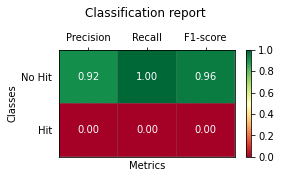

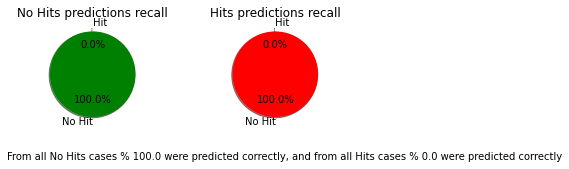

Cohen's kappa coefficient is same as the baseline:  0.0

Total Accuracy percentaje is same as the baseline: % 92.31

Hit Precision is same as the baseline:  0.0

Hit Recall is same as the baseline:  0.0

No Hit Precision is same as the baseline:  0.92

No Hit Recall is same as the baseline:  1.0

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit
True             
No Hit      18000
Yes Hit      1500



In [5]:
# zero rule algorithm for classification
def zero_rule_algorithm_fit(train, test):
    #DO NOTHING
    pass

def zero_rule_algorithm_classification(test):
    prediction = 0
    predicted = [prediction for i in range(len(test))]
    return predicted

repite_model_predict_algorithm(zero_rule_algorithm_fit, zero_rule_algorithm_classification, 100, 0.4)

## Decision Tree

<h3>Multiple experiments average result:</h3>

Total Accuracy: %91.24
Cohen's kappa coefficient: 0.38


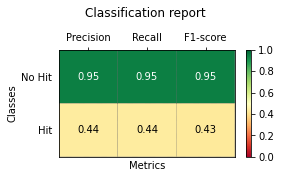

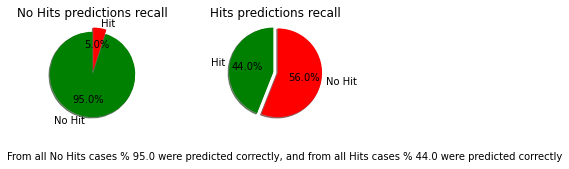

Cohen's kappa coefficient is <span style="color:green"> +0.38</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -1.07</span> below the baseline.

Hit Precision is <span style="color:green"> +0.44</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.44</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.03</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.05</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     171319     8681
Yes Hit      8392     6608



In [6]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()

repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 0.4)

As we can see we have a good 'Total Accuracy' of 92 % and a good recall for false cases. The problem here is that it seems to be an overfitting given that the algorithm assert with almost the 96% false cases but when it is a true case we have around 48%. 

I decided to add two pie plots only to visualize the recall of both decisions, and in particular to show falses negatives percentage. In a real case we would try to avoid those negatives cases in order to avoid when the model predict that it will not be collision but it finally happens.

Regarding that, we can consider that the fact of having less true cases for training the model may be a problem for this investigation. However, we will try to see different approachs with the same data to deal with that.

As we can see in the Confusion Matrix we have almost 15 k true cases and we only predict almost 7k correctly.

Also this problem is repeated with 0.1, 0.2, 0.3 and 0.5 test_size.

## KNN classifier

### Search for best n neighbors number

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

#create new a knn model
knn2 = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)
#fit model to data
knn_gscv.fit(X, Y)
#check top performing n_neighbors value
knn_gscv.best_params_

{'n_neighbors': 4}

### KNN classifier with n=4

<h3>Multiple experiments average result:</h3>

Total Accuracy: %93.02
Cohen's kappa coefficient: 0.22


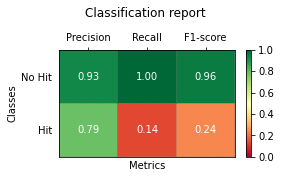

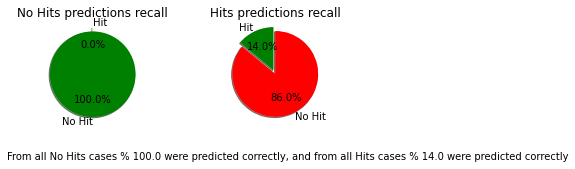

Cohen's kappa coefficient is <span style="color:green"> +0.22</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:green">% +0.71</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Precision is <span style="color:green"> +0.79</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.14</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.01</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is same as the baseline:  1.0

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     224213      787
Yes Hit     16247     2753



In [10]:
knn = KNeighborsClassifier(n_neighbors = 4)

repite_model_predict_algorithm(knn.fit, knn.predict, 1000, 0.5)

This case is a clear example of overfitting. We have a huge percentage of correct 'No Hit Predictions' but the opposite with 'Hit predictions'. The model seems to be used to predict that the driver it's not going to crash which translates into a high percentage of false negatives cases.

I used 20% of data set for testing, because performs better in this case.

## Random Forest

<h3>Multiple experiments average result:</h3>

Total Accuracy: %93.60
Cohen's kappa coefficient: 0.38


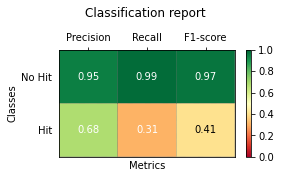

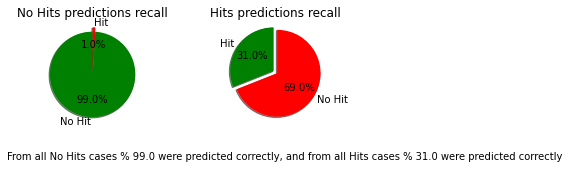

Cohen's kappa coefficient is <span style="color:green"> +0.38</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:green">% +1.29</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Precision is <span style="color:green"> +0.68</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.31</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.03</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.01</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     134177     1823
Yes Hit      7583     3417



In [26]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.3)

The same problem can be seen with this model, the best recall achieved was %30 trying with different training sizes.

# Over sampling data

Now we will try increasing the numbers of true cases with different over sampling approachs:

## Random Over Sampler

In [12]:
from imblearn.over_sampling import RandomOverSampler

def random_over_sampler_split(test_size):
    ros = RandomOverSampler()
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, stratify=Y)
    #X_resampled, y_resampled = ros.fit_sample(X_train, y_train)
    X_resampled, y_resampled = X_train, y_train
    return X_resampled, X_test, y_resampled, y_test

def print_over_sampling_fuction(split_function, test_size):
    X_resampled, X_test, y_resampled, y_test = split_function(test_size)
    print_split_data_set(X_resampled, X_test, y_resampled, y_test)

In [13]:
def print_split_data_set(X_train, X_test, y_train, y_test):
    print("Training True  : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 1]), (len(y_train[y_train[:] == 1])/len(y_train) * 100.0)))
    print("Training False : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 0]), (len(y_train[y_train[:] == 0])/len(y_train) * 100.0)))
    print("")
    print("Test True      : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 1]), (len(y_test[y_test[:] == 1])/len(y_test) * 100.0)))
    print("Test False     : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 0]), (len(y_test[y_test[:] == 0])/len(y_test) * 100.0)))
    
print_over_sampling_fuction(random_over_sampler_split, 0.4)

Training True  : 22 (7.53%)
Training False : 270 (92.47%)

Test True      : 15 (7.69%)
Test False     : 180 (92.31%)


Here we can see that False cases were splitted normally and "Training True" cases are now equals to falses.

### Decision Tree

This algorith was ignore because results were worst than before (without over sampling data)

### KNN classifier

<h3>Multiple experiments average result:</h3>

Total Accuracy: %93.98
Cohen's kappa coefficient: 0.29


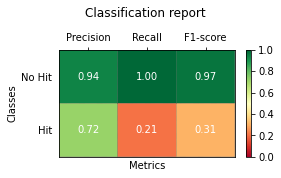

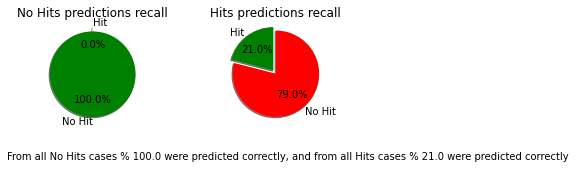

Cohen's kappa coefficient is <span style="color:green"> +0.29</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:green">% +1.67</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Precision is <span style="color:green"> +0.72</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.21</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.02</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is same as the baseline:  1.0

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      90653      347
Yes Hit      5557     1443



In [14]:
knn = KNeighborsClassifier(n_neighbors = 4)

repite_model_predict_algorithm(knn.fit, knn.predict, 1000, 0.2, random_over_sampler_split)

With over sampling Knn seems to be better at recall, but it lose a lot of precision comparing without over sampling data.

### Random Forest

<h3>Multiple experiments average result:</h3>

Total Accuracy: %93.29
Cohen's kappa coefficient: 0.36


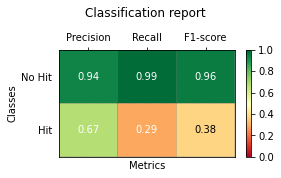

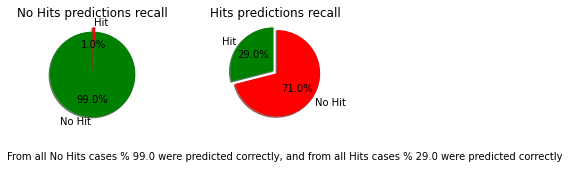

Cohen's kappa coefficient is <span style="color:green">+ 0.36</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:green">+ 0.98</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Precision is <span style="color:green">+ 0.67</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green">+ 0.29</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green">+ 0.02</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.01</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     177634     2366
Yes Hit     10724     4276



In [14]:
rf_model = RandomForestClassifier()
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.4, random_over_sampler_split)

For random forest there is no difference with random over sampling data.

## SMOTE

In [18]:
from imblearn.over_sampling import SMOTE, ADASYN

def smote_over_sampler_split(test_size):
    smote = SMOTE()
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, stratify=Y)
    X_resampled, y_resampled = smote.fit_sample(X_train, y_train)
    return X_resampled, X_test, y_resampled, y_test

print_over_sampling_fuction(smote_over_sampler_split, 0.4)

Training True  : 270 (50.00%)
Training False : 270 (50.00%)

Test True      : 15 (7.69%)
Test False     : 180 (92.31%)


### Decision Tree

<h3>Multiple experiments average result:</h3>

Total Accuracy: %86.71
Cohen's kappa coefficient: 0.24


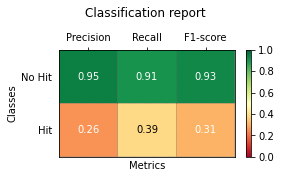

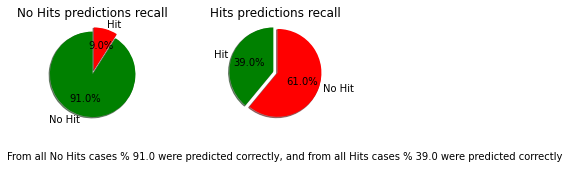

Cohen's kappa coefficient is <span style="color:green">+ 0.24</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red"> -5.6</span> below the baseline.

Hit Precision is <span style="color:green">+ 0.26</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green">+ 0.39</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green">+ 0.03</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.09</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     163198    16802
Yes Hit      9114     5886



In [16]:
clf = tree.DecisionTreeClassifier()

repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 0.4, smote_over_sampler_split)

Decision Tree doesn't change results with over sampling data.

### KNN classifier

<h3>Multiple experiments average result:</h3>

Total Accuracy: %83.97
Cohen's kappa coefficient: 0.24


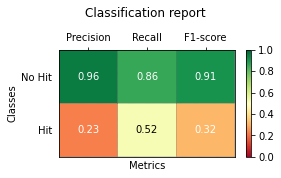

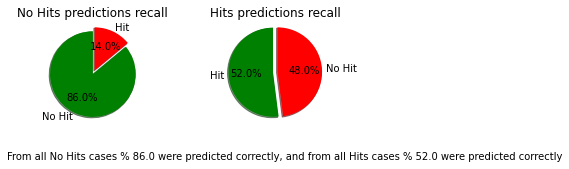

Cohen's kappa coefficient is <span style="color:green">+ 0.24</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red"> -8.34</span> below the baseline.

Hit Precision is <span style="color:green">+ 0.23</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green">+ 0.52</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green">+ 0.04</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.14</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      78653    12347
Yes Hit      3364     3636



In [17]:
knn = KNeighborsClassifier(n_neighbors = 4)

repite_model_predict_algorithm(knn.fit, knn.predict, 1000, 0.2, smote_over_sampler_split)

With Smote we have better Recall but worst precision.

### Random Forest

<h3>Multiple experiments average result:</h3>

Total Accuracy: %91.75
Cohen's kappa coefficient: 0.35


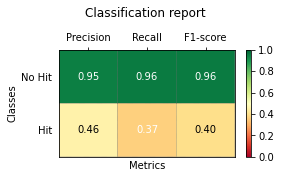

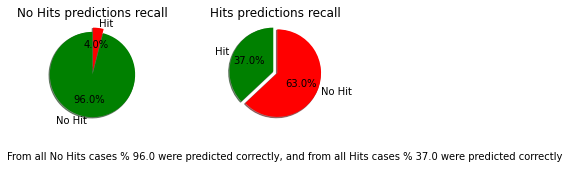

Cohen's kappa coefficient is <span style="color:green">+ 0.35</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red"> -0.56</span> below the baseline.

Hit Precision is <span style="color:green">+ 0.46</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green">+ 0.37</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green">+ 0.03</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.04</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     130808     5192
Yes Hit      6934     4066



In [18]:
rf_model = RandomForestClassifier()
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.3, smote_over_sampler_split)

This are similars results as Randon Forest without over sampling, but with a considerable worst precision. It is still possible to notice the overfitting.

## ADASYN

In [19]:
def adasyn_over_sampler_split(test_size):
    adasyn = ADASYN()
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, stratify=Y)
    X_resampled, y_resampled = adasyn.fit_sample(X_train, y_train)
    return X_resampled, X_test, y_resampled, y_test

print_over_sampling_fuction(adasyn_over_sampler_split, 0.4)

Training True  : 271 (50.09%)
Training False : 270 (49.91%)

Test True      : 15 (7.69%)
Test False     : 180 (92.31%)


This oversampling it's not totally exactly when doing the true training cases. So it's not exactly 50% of each.

### Decision Tree

Ignored

### KNN classifier

<h3>Multiple experiments average result:</h3>

Total Accuracy: %82.81
Cohen's kappa coefficient: 0.24


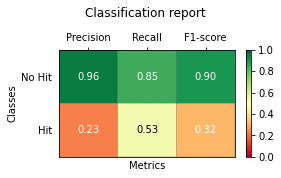

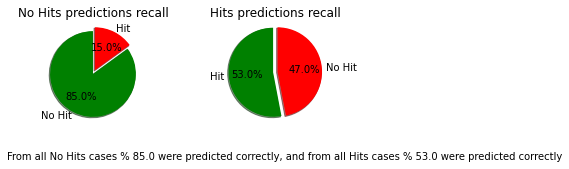

Cohen's kappa coefficient is <span style="color:green">+ 0.24</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red"> -9.5</span> below the baseline.

Hit Precision is <span style="color:green">+ 0.23</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green">+ 0.53</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green">+ 0.04</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.15</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     153598    26402
Yes Hit      7121     7879



In [20]:
knn = KNeighborsClassifier(n_neighbors = 4)

repite_model_predict_algorithm(knn.fit, knn.predict, 1000, 0.4, adasyn_over_sampler_split)

Similar recall to Smote but worst precision.

### Random Forest

<h3>Multiple experiments average result:</h3>

Total Accuracy: %91.44
Cohen's kappa coefficient: 0.32


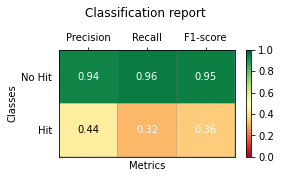

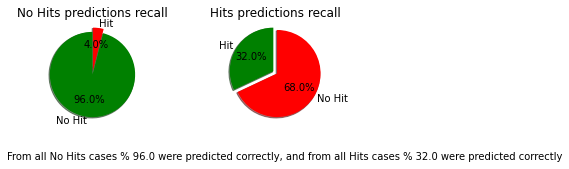

Cohen's kappa coefficient is <span style="color:green">+ 0.32</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red"> -0.87</span> below the baseline.

Hit Precision is <span style="color:green">+ 0.44</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green">+ 0.32</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green">+ 0.02</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.04</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     173518     6482
Yes Hit     10205     4795



In [21]:
rf_model = RandomForestClassifier()
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.4, adasyn_over_sampler_split)

Worst results than smote and no over sampling.

# Changing training data

I will try training the data with the same numbers of false cases and true cases but this time with less false cases:

In [20]:
def equal_cases_split(training_size_positives):
    return split_cases(training_size_positives, training_size_positives)

def double_false_cases_split(training_size_positives):
    return split_cases(training_size_positives, training_size_positives*2)

def split_cases(positive_training_size, negative_training_size):
    positives = data.loc[df['hadCollision'] == 1].copy()
    negatives = data.loc[df['hadCollision'] == 0].copy()
    test_size_pos = len(positives) - positive_training_size
    test_size_neg = len(negatives) - negative_training_size

    X_train_pos, X_test_pos = train_test_split(positives, train_size=positive_training_size, test_size=test_size_pos)
    X_train_neg, X_test_neg = train_test_split(negatives, train_size=negative_training_size, test_size=test_size_neg)
    X_train_total = X_train_pos.append(X_train_neg)
    X_test_total = X_test_pos.append(X_test_neg)

    X_train_total = X_train_total.sample(frac=1).reset_index(drop=True)
    X_test_total = X_test_total.sample(frac=1).reset_index(drop=True)
    X_train = X_train_total.drop('hadCollision', axis=1) 
    y_train = X_train_total['hadCollision']

    X_test = X_test_total.drop('hadCollision', axis=1) 
    y_test = X_test_total['hadCollision']
    return X_train, X_test, y_train, y_test

def print_results_with_size(split_function, train_size_pos):
    X_train, X_test, y_train, y_test = split_function(train_size_pos)
    print("Training True  : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 1]), (len(y_train[y_train[:] == 1])/len(y_train) * 100.0)))
    print("Training False : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 0]), (len(y_train[y_train[:] == 0])/len(y_train) * 100.0)))
    print("")
    print("Test True      : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 1]), (len(y_test[y_test[:] == 1])/len(y_test) * 100.0)))
    print("Test False     : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 0]), (len(y_test[y_test[:] == 0])/len(y_test) * 100.0)))

In [21]:
print_results_with_size(equal_cases_split, 30)

Training True  : 30 (50.00%)
Training False : 30 (50.00%)

Test True      : 7 (1.64%)
Test False     : 420 (98.36%)


We have now a training set of only 60 cases with 50% hits and 50% no hits. I decided to take 30 true cases as it's almost de 80% of true cases for training.

### Decision Tree

<h3>Multiple experiments average result:</h3>

Total Accuracy: %73.26
Cohen's kappa coefficient: 0.05


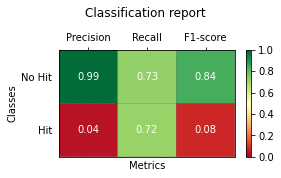

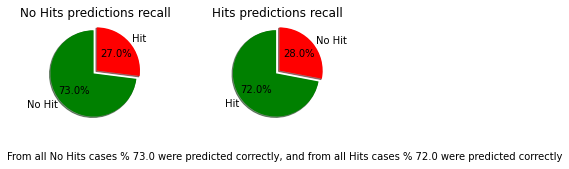

Cohen's kappa coefficient is <span style="color:green">+ 0.05</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red"> -19.05</span> below the baseline.

Hit Precision is <span style="color:green">+ 0.04</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green">+ 0.72</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green">+ 0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.27</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     307803   112197
Yes Hit      1982     5018



In [24]:
clf = tree.DecisionTreeClassifier()

repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 30, equal_cases_split)

The recall is strongly increased with this approach, but now the "No hit" predictions are not as good as before and that makes a presicion for "Yes Hit"'s cases really bad due to compare 5k correct predictions with more than 100k false positives.

In [25]:
print_results_with_size(double_false_cases_split, 20)

Training True  : 20 (33.33%)
Training False : 40 (66.67%)

Test True      : 17 (3.98%)
Test False     : 410 (96.02%)


Trying with the double of false cases for training in order to get more precision of "Yes Hit" cases, but this time taking only 20 true cases for training.

<h3>Multiple experiments average result:</h3>

Total Accuracy: %82.07
Cohen's kappa coefficient: 0.17


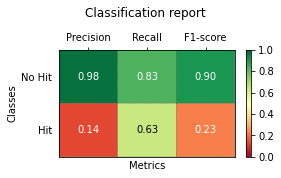

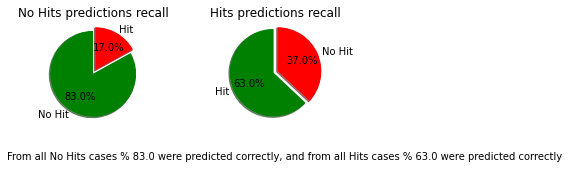

Cohen's kappa coefficient is <span style="color:green">+ 0.17</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red"> -10.24</span> below the baseline.

Hit Precision is <span style="color:green">+ 0.14</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green">+ 0.63</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green">+ 0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.17</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     339740    70260
Yes Hit      6315    10685



In [26]:
clf = tree.DecisionTreeClassifier()

repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 20, double_false_cases_split)

We could increase the recall of "No Hit", which affects to "Yes Hit" precision on almost the triple, but is still low. 

### Knn

<h3>Multiple experiments average result:</h3>

Total Accuracy: %87.52
Cohen's kappa coefficient: 0.10


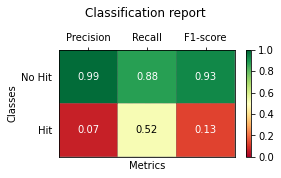

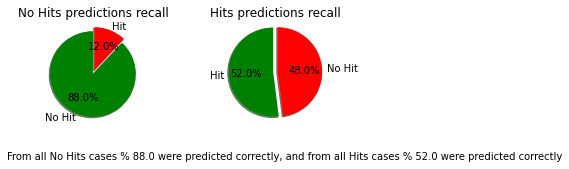

Cohen's kappa coefficient is <span style="color:green">+ 0.1</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red"> -4.79</span> below the baseline.

Hit Precision is <span style="color:green">+ 0.07</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green">+ 0.52</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green">+ 0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.12</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     370079    49921
Yes Hit      3348     3652



In [27]:
knn = KNeighborsClassifier(n_neighbors = 4)

repite_model_predict_algorithm(knn.fit, knn.predict, 1000,  30, equal_cases_split)

Worst metrics as before

<h3>Multiple experiments average result:</h3>

Total Accuracy: %94.93
Cohen's kappa coefficient: 0.21


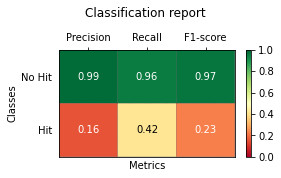

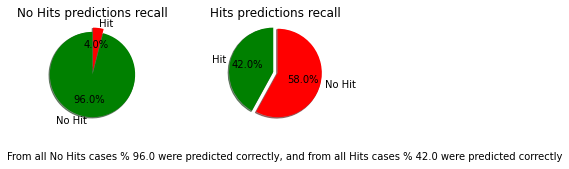

Cohen's kappa coefficient is <span style="color:green">+ 0.21</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:green">+ 2.62</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Precision is <span style="color:green">+ 0.16</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green">+ 0.42</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green">+ 0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.04</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     373880    16120
Yes Hit      4026     2974



In [28]:
knn = KNeighborsClassifier(n_neighbors = 4)

repite_model_predict_algorithm(knn.fit, knn.predict, 1000,  30, double_false_cases_split)

We recorver the recall of "No Hits" predictions but it's not enougth to have good precision of "Yes Hit"

### Random Forest

<h3>Multiple experiments average result:</h3>

Total Accuracy: %81.02
Cohen's kappa coefficient: 0.09


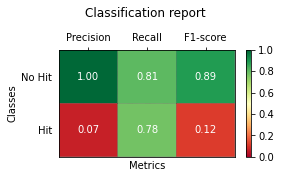

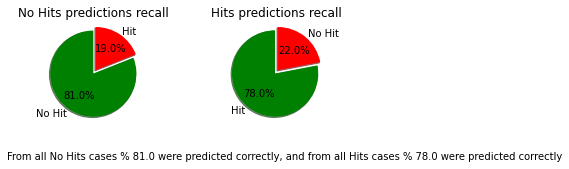

Cohen's kappa coefficient is <span style="color:green">+ 0.09</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red"> -11.29</span> below the baseline.

Hit Precision is <span style="color:green">+ 0.07</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green">+ 0.78</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green">+ 0.08</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.19</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     340535    79465
Yes Hit      1573     5427



In [29]:
rf_model = RandomForestClassifier()
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 30, equal_cases_split)

The recall it's considerable better with this configuration. However the model now seems to see a lot of cases positives than before. This doesn't affect "No hit" precision or recall, but the precision of "Yes Hit" cases it's considerable worst than before. This means we have now a lot of False Positive cases.

We can see in the confusion matrix that almost 72k cases were predicted with a collision and there were false hits. In real life this will be a problem because we would be alerting for nothing really, but in fact it is not as important as the opposite case.

<h3>Multiple experiments average result:</h3>

Total Accuracy: %91.04
Cohen's kappa coefficient: 0.32


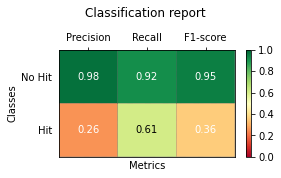

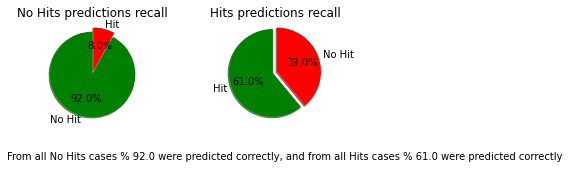

Cohen's kappa coefficient is <span style="color:green">+ 0.32</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red"> -1.27</span> below the baseline.

Hit Precision is <span style="color:green">+ 0.26</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green">+ 0.61</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green">+ 0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.08</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     378419    31581
Yes Hit      6685    10315



In [30]:
rf_model = RandomForestClassifier()
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 20, double_false_cases_split)

There is an improvement with the precision of "Yes Hit" but still low. On the other hand, the recall of "Yes Hit" it's not as good as before, but in the combination of both (f1-score) this is a better configuration.

The preference on the result will depend on the weigth of those classes.

# Weights classes

## Balanced

### Decision Tree

<h3>Multiple experiments average result:</h3>

Total Accuracy: %90.19
Cohen's kappa coefficient: 0.24


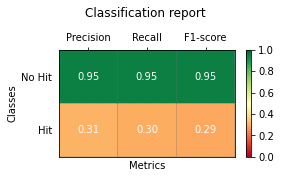

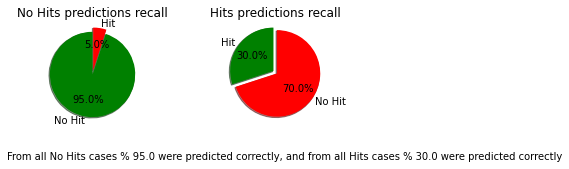

Cohen's kappa coefficient is <span style="color:green">+ 0.24</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red"> -2.12</span> below the baseline.

Hit Precision is <span style="color:green">+ 0.31</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green">+ 0.3</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green">+ 0.03</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.05</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      86309     4691
Yes Hit      4922     2078



In [31]:
clf = tree.DecisionTreeClassifier(class_weight='balanced')

repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 0.2)

Worst than default case.

### KNN

Default value is 'uniform' or balance, so I will try with distance

<h3>Multiple experiments average result:</h3>

Total Accuracy: %93.32
Cohen's kappa coefficient: 0.34


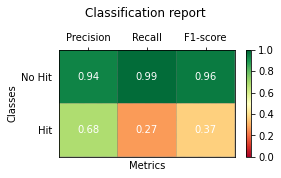

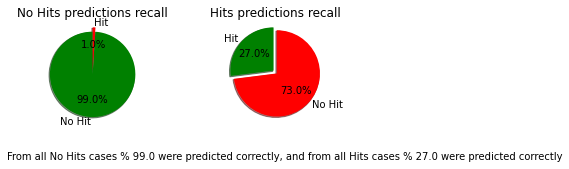

Cohen's kappa coefficient is <span style="color:green">+ 0.34</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:green">+ 1.01</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Precision is <span style="color:green">+ 0.68</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green">+ 0.27</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green">+ 0.02</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.01</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     178003     1997
Yes Hit     11024     3976



In [32]:
knn = KNeighborsClassifier(n_neighbors=4, weights='distance')

repite_model_predict_algorithm(knn.fit, knn.predict, 1000,  0.4)

Same overfitting as default case

### Random Forest

#### Balanced

<h3>Multiple experiments average result:</h3>

Total Accuracy: %93.18
Cohen's kappa coefficient: 0.18


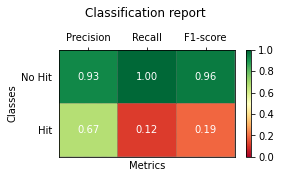

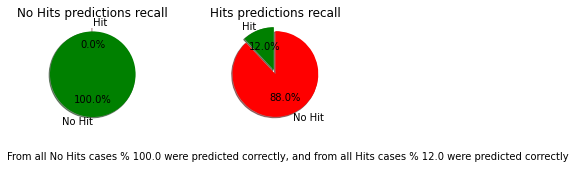

Cohen's kappa coefficient is <span style="color:green">+ 0.18</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:green">+ 0.87</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Precision is <span style="color:green">+ 0.67</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green">+ 0.12</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green">+ 0.01</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is same as the baseline: 1.0

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     135699      301
Yes Hit      9729     1271



In [33]:
rf_model = RandomForestClassifier(class_weight="balanced")
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.3)

Same overfitting as default.

#### Balanced Subsample

<h3>Multiple experiments average result:</h3>

Total Accuracy: %93.19
Cohen's kappa coefficient: 0.18


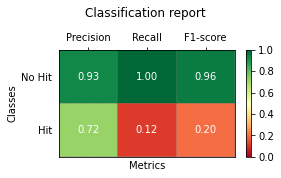

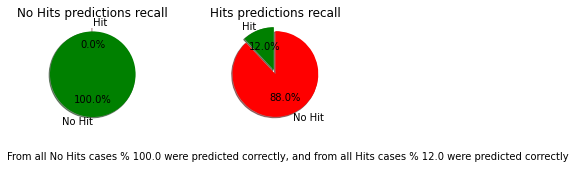

Cohen's kappa coefficient is <span style="color:green">+ 0.18</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:green">+ 0.88</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Precision is <span style="color:green">+ 0.72</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green">+ 0.12</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green">+ 0.01</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is same as the baseline: 1.0

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     135684      316
Yes Hit      9694     1306



In [34]:
rf_model = RandomForestClassifier(class_weight="balanced_subsample")
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.3)

Same overfitting as default

### Decision Tree

In [35]:
from IPython.core.display import display, Markdown

def print_header(header):
    raw_html = "<h3>"+header+"</h3>"
    display( Markdown(raw_html) )

<h3>Running: Default model-prediction</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %91.34
Cohen's kappa coefficient: 0.41


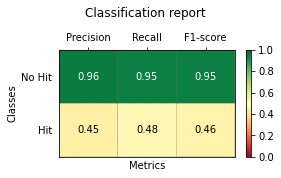

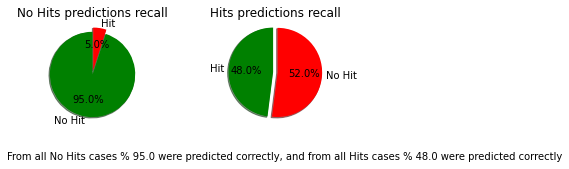

Cohen's kappa coefficient is <span style="color:green">+ 0.41</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red"> -0.97</span> below the baseline.

Hit Precision is <span style="color:green">+ 0.45</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green">+ 0.48</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green">+ 0.04</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.05</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     170849     9151
Yes Hit      7733     7267



<h3>Running: Random Over Sampler</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %91.97
Cohen's kappa coefficient: 0.43


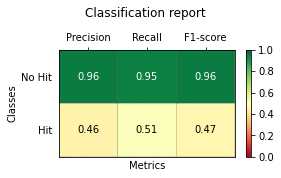

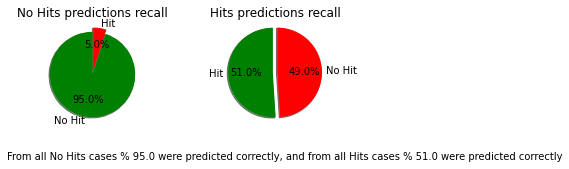

Cohen's kappa coefficient is <span style="color:green">+ 0.43</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red"> -0.34</span> below the baseline.

Hit Precision is <span style="color:green">+ 0.46</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green">+ 0.51</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green">+ 0.04</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.05</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      86587     4413
Yes Hit      3458     3542



<h3>Running: SMOTE</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %87.62
Cohen's kappa coefficient: 0.36


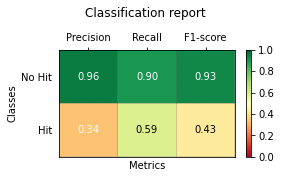

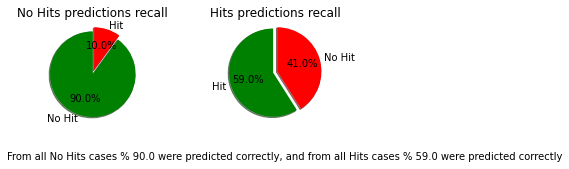

Cohen's kappa coefficient is <span style="color:green">+ 0.36</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red"> -4.69</span> below the baseline.

Hit Precision is <span style="color:green">+ 0.34</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green">+ 0.59</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green">+ 0.04</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.1</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     161938    18062
Yes Hit      6076     8924



<h3>Running: ADASYN</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %81.19
Cohen's kappa coefficient: 0.22


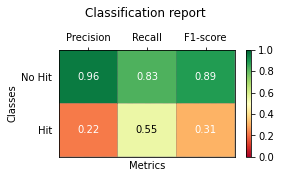

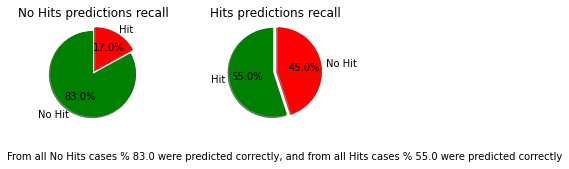

Cohen's kappa coefficient is <span style="color:green">+ 0.22</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red"> -11.12</span> below the baseline.

Hit Precision is <span style="color:green">+ 0.22</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green">+ 0.55</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green">+ 0.04</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.17</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     150087    29913
Yes Hit      6761     8239



<h3>Running: Equal training cases</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %75.05
Cohen's kappa coefficient: 0.07


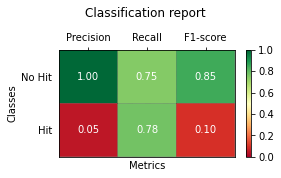

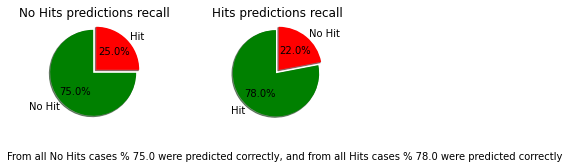

Cohen's kappa coefficient is <span style="color:green">+ 0.07</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red"> -17.26</span> below the baseline.

Hit Precision is <span style="color:green">+ 0.05</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green">+ 0.78</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green">+ 0.08</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.25</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     314995   105005
Yes Hit      1515     5485



<h3>Running: Double false training cases</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %83.52
Cohen's kappa coefficient: 0.11


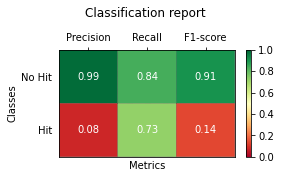

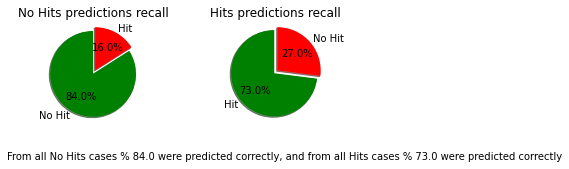

Cohen's kappa coefficient is <span style="color:green">+ 0.11</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red"> -8.79</span> below the baseline.

Hit Precision is <span style="color:green">+ 0.08</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green">+ 0.73</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green">+ 0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.16</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     326480    63520
Yes Hit      1887     5113



In [36]:
def run_all_models(clf):
    print_header("Running: Default model-prediction")

    repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 0.4)

    print_header("Running: Random Over Sampler")

    repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 0.2, random_over_sampler_split)

    print_header("Running: SMOTE")

    repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 0.4, smote_over_sampler_split)

    print_header("Running: ADASYN")

    repite_model_predict_algorithm(knn.fit, knn.predict, 1000, 0.4, adasyn_over_sampler_split)

    print_header("Running: Equal training cases")

    repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 30, equal_cases_split)

    print_header("Running: Double false training cases")

    repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 30, double_false_cases_split)
    
clf = tree.DecisionTreeClassifier(class_weight={0:10, 1:1})
run_all_models(clf)

Regarding Hits predictions recall we can see a really good performance with "Equal training cases" but again still a bad precision for this class. 

Regarding F1-score, it means seen precision and recall, we acceptable performances with Smote and Random over samplers, and with default case we have a similar performance in each component.

### Knn

I didn't find Knn class_weigths, it has a function weigth but I think is only weigths per feature:
    
    - [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.

### Random Forest

<h3>Running: Default model-prediction</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %93.30
Cohen's kappa coefficient: 0.41


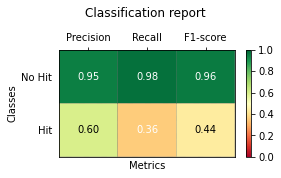

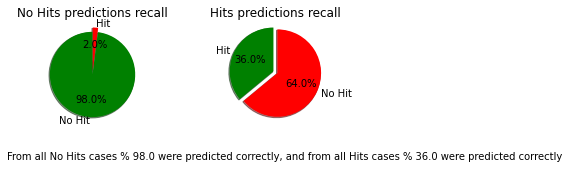

Cohen's kappa coefficient is <span style="color:green">+ 0.41</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:green">+ 0.99</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Precision is <span style="color:green">+ 0.6</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green">+ 0.36</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green">+ 0.03</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.02</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     133143     2857
Yes Hit      6989     4011



<h3>Running: Random Over Sampler</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %93.16
Cohen's kappa coefficient: 0.40


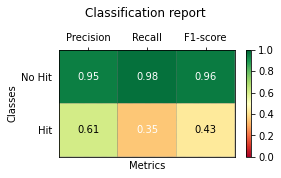

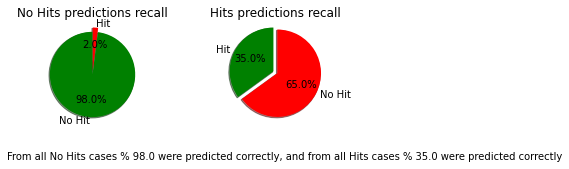

Cohen's kappa coefficient is <span style="color:green">+ 0.4</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:green">+ 0.85</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Precision is <span style="color:green">+ 0.61</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green">+ 0.35</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green">+ 0.03</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.02</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     176414     3586
Yes Hit      9755     5245



<h3>Running: SMOTE</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %91.47
Cohen's kappa coefficient: 0.50


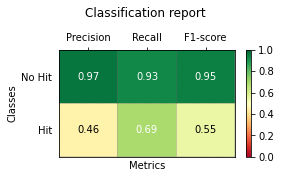

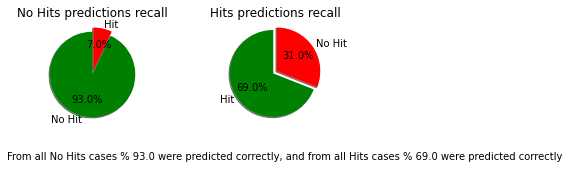

Cohen's kappa coefficient is <span style="color:green">+ 0.5</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red"> -0.84</span> below the baseline.

Hit Precision is <span style="color:green">+ 0.46</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green">+ 0.69</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green">+ 0.05</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.07</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     126870     9130
Yes Hit      3407     7593



<h3>Running: ADASYN</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %91.12
Cohen's kappa coefficient: 0.49


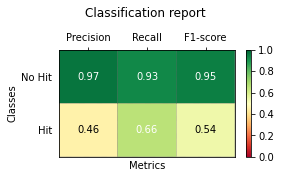

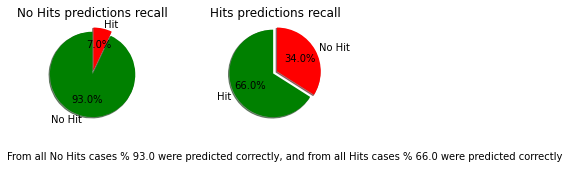

Cohen's kappa coefficient is <span style="color:green">+ 0.49</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red"> -1.19</span> below the baseline.

Hit Precision is <span style="color:green">+ 0.46</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green">+ 0.66</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green">+ 0.05</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.07</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     167741    12259
Yes Hit      5055     9945



<h3>Running: Equal training cases</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %79.23
Cohen's kappa coefficient: 0.09


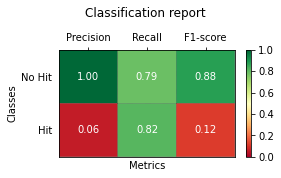

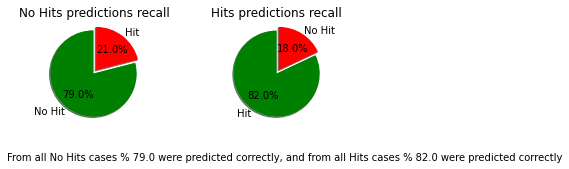

Cohen's kappa coefficient is <span style="color:green">+ 0.09</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red"> -13.08</span> below the baseline.

Hit Precision is <span style="color:green">+ 0.06</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green">+ 0.82</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green">+ 0.08</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.21</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     332571    87429
Yes Hit      1249     5751



<h3>Running: Double false training cases</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %89.28
Cohen's kappa coefficient: 0.17


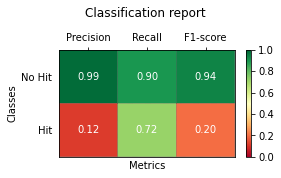

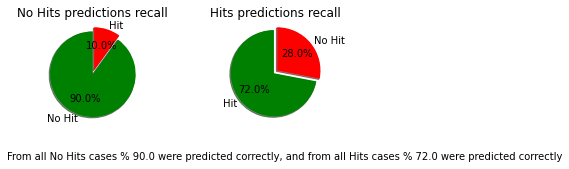

Cohen's kappa coefficient is <span style="color:green">+ 0.17</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red"> -3.03</span> below the baseline.

Hit Precision is <span style="color:green">+ 0.12</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green">+ 0.72</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green">+ 0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.1</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     349437    40563
Yes Hit      1977     5023



In [37]:
def run_all_models(rf_model):
    print_header("Running: Default model-prediction")

    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.3)
    
    print_header("Running: Random Over Sampler")

    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.4, random_over_sampler_split)

    print_header("Running: SMOTE")

    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.3, smote_over_sampler_split)

    print_header("Running: ADASYN")

    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.4, adasyn_over_sampler_split)
    
    print_header("Running: Equal training cases")

    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 30, equal_cases_split)

    print_header("Running: Double false training cases")

    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 30, double_false_cases_split)
    
rf_model = RandomForestClassifier(class_weight={0:10, 1:1})
run_all_models(rf_model)

We can see again very good recalls for Hits predictions in Equal and Double False training cases. However regarding both variables Precision and Recall, the best prediction seems to be with SMOTE over sampling having acceptables metrics in both.

<h3>Multiple experiments average result:</h3>

Total Accuracy: %91.31
Cohen's kappa coefficient: 0.49


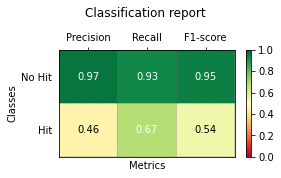

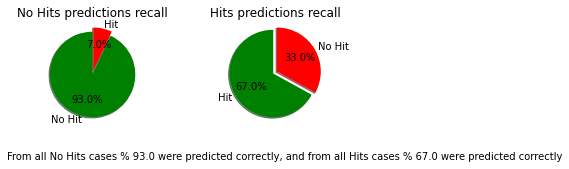

Cohen's kappa coefficient is <span style="color:green"> +0.49</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -1.0</span> below the baseline.

Hit Precision is <span style="color:green"> +0.46</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.67</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.05</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.07</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     126840     9160
Yes Hit      3618     7382



In [27]:
rf_model = RandomForestClassifier(class_weight={0:10, 1:1})

repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.3, smote_over_sampler_split)